# Chapter 4. Classification

In [1]:
library("class")
library("doMC")
library("dplyr")
library("foreach")
library("GGally")
library("ggplot2")
library("ISLR")
library("MASS")
library("pheatmap")
library("reshape2")

registerDoMC(8)

Loading required package: foreach
Loading required package: iterators
Loading required package: parallel

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘GGally’

The following object is masked from ‘package:dplyr’:

    nasa


Attaching package: ‘MASS’

The following object is masked from ‘package:dplyr’:

    select



## Lab: Logistic Regression, LDA, QDA, and KNN

### The Stock Market Data

We will begin by examining some numerical and graphical summaries of the **Smarket** data, which is part of the `ISLR` library. This data set consists of percentage returns for the S&P 500 stock index over 1,250 days, from the beginning of 2001 until the end of 2005. For each date, we have recorded the percentage returns for each of the ﬁve previous trading days, **Lag1** through **Lag5**. We have also recorded **Volume** (the number of shares traded on the previous day, in billions), **Today** (the percentage return on the date in question) and **Direction** (whether the market was *Up* or *Down* on this date).

**S&P Stock Market Data**

A data frame with 1250 observations on the following 9 variables.

**Variable** | **Description**
:- | :-
**Year** |    The year that the observation was recorded
**Lag1** |    Percentage return for previous day
**Lag2** |    Percentage return for 2 days previous
**Lag3** |    Percentage return for 3 days previous
**Lag4** |    Percentage return for 4 days previous
**Lag5** |    Percentage return for 5 days previous
**Volume** |    Volume of shares traded (number of daily shares traded in billions)
**Today** |    Percentage return for today
**Direction** |    A factor with levels Down and Up indicating whether the market had a positive or negative return on a given day


In [2]:
head(Smarket)

Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up
2001,0.213,0.614,-0.623,1.032,0.959,1.3491,1.392,Up


Observe how the percentage rolls the diagonals. It looks the rows are ordered
by the day of the year.

In [3]:
dim(Smarket)

[1] 1250    9

In [4]:
summary(Smarket[, c("Year", "Volume", "Direction")])

      Year          Volume       Direction 
 Min.   :2001   Min.   :0.3561   Down:602  
 1st Qu.:2002   1st Qu.:1.2574   Up  :648  
 Median :2003   Median :1.4229             
 Mean   :2003   Mean   :1.4783             
 3rd Qu.:2004   3rd Qu.:1.6417             
 Max.   :2005   Max.   :3.1525             

In [5]:
summary(Smarket[, c("Today", paste0("Lag", 1:5))])

     Today                Lag1                Lag2          
 Min.   :-4.922000   Min.   :-4.922000   Min.   :-4.922000  
 1st Qu.:-0.639500   1st Qu.:-0.639500   1st Qu.:-0.639500  
 Median : 0.038500   Median : 0.039000   Median : 0.039000  
 Mean   : 0.003138   Mean   : 0.003834   Mean   : 0.003919  
 3rd Qu.: 0.596750   3rd Qu.: 0.596750   3rd Qu.: 0.596750  
 Max.   : 5.733000   Max.   : 5.733000   Max.   : 5.733000  
      Lag3                Lag4                Lag5         
 Min.   :-4.922000   Min.   :-4.922000   Min.   :-4.92200  
 1st Qu.:-0.640000   1st Qu.:-0.640000   1st Qu.:-0.64000  
 Median : 0.038500   Median : 0.038500   Median : 0.03850  
 Mean   : 0.001716   Mean   : 0.001636   Mean   : 0.00561  
 3rd Qu.: 0.596750   3rd Qu.: 0.596750   3rd Qu.: 0.59700  
 Max.   : 5.733000   Max.   : 5.733000   Max.   : 5.73300  

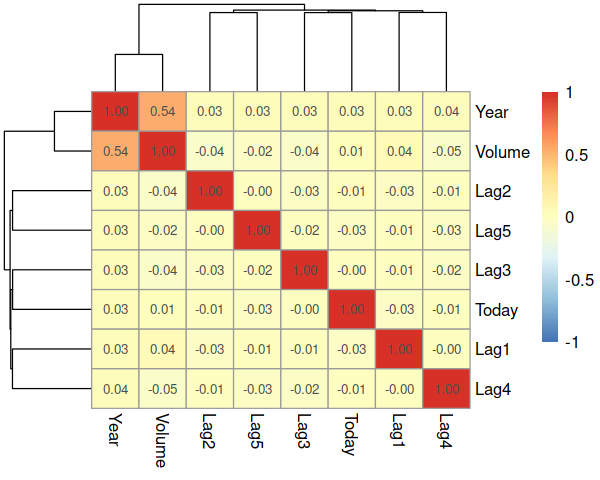

In [6]:
options(repr.plot.width = 5, repr.plot.height = 4)

pheatmap(cor(Smarket[, setdiff(names(Smarket), "Direction")]),
         display_numbers = TRUE,
         breaks = seq(-1, 1, 0.02))

The only predictors that present some correlation are **Year** and **Volume**.
Not even **Today** with **Lag1** (Yesterday) have significant correlation.
As we know the data is ordered, we can plot the volume over time:

Warning message:
“Removed 5 rows containing missing values (geom_point).”

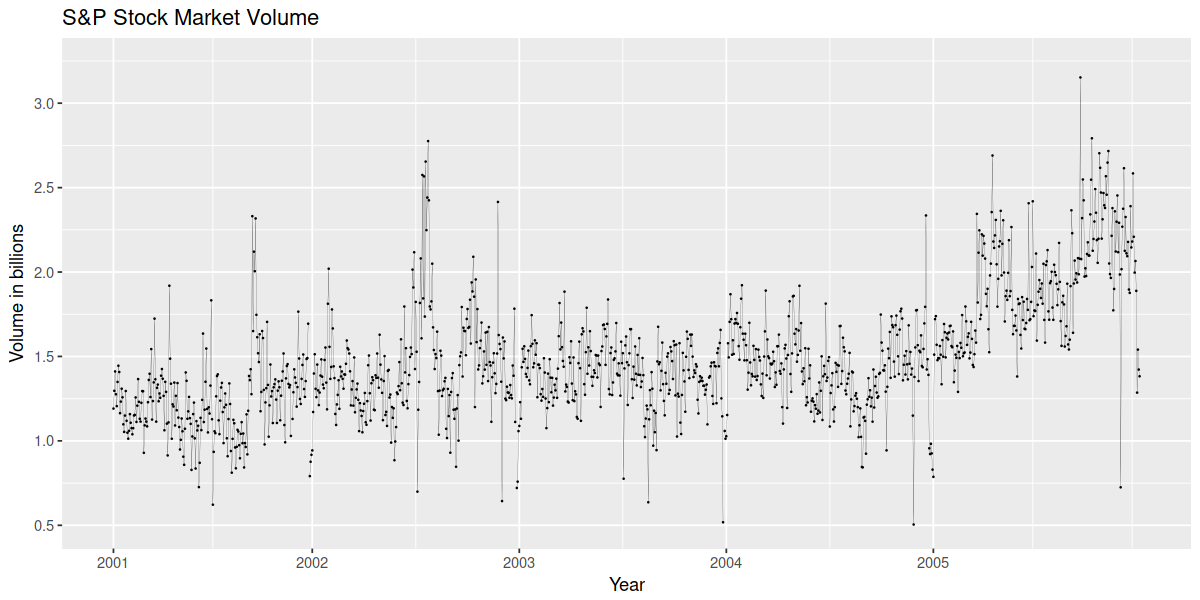

In [7]:
n <- nrow(Smarket)

row.of.the.first.day.of.year <- Smarket %>% 
    group_by(Year) %>% 
    summarise(days = n()) %>% 
    mutate(first.day = cumsum(days) - days + 1)

by.year <- cbind(Day = 1:n, Smarket)

options(repr.plot.width = 10, repr.plot.height = 5)
ggplot(by.year, aes(Day, Volume)) + 
    geom_point(size = 0.1) + 
    geom_line(size = 0.05) +
    scale_y_continuous(
        limits = c(0.5, 3.25),
        breaks = seq(0.5, 3.25, 0.5)
    ) +
    scale_x_continuous(
        limits = c(1, n),
        breaks = row.of.the.first.day.of.year$first.day,
        labels = Smarket$Year[row.of.the.first.day.of.year$first.day]) +
    xlab("Year") +
    ylab("Volume in billions") +
    ggtitle("S&P Stock Market Volume")

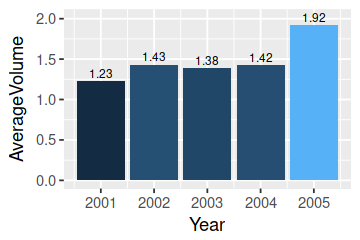

In [8]:
by_year <- Smarket %>% group_by(Year) %>% summarise(AverageVolume = mean(Volume))

options(repr.plot.width = 3, repr.plot.height = 2)
ggplot(by_year, aes(Year, AverageVolume, fill = AverageVolume)) +
    geom_bar(stat = "identity") +
    geom_text(aes(label = round(AverageVolume, 2)), nudge_y = 0.1, size = 2.5) +
    guides(fill = FALSE)

The average number of shares traded daily increased from 2001 to 2005 by
$1.92 - 1.23 = 0.69$ billions.

### Logistic Regression

In [9]:
glm.fits <- glm(Direction ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + Volume, 
                data = Smarket, family = binomial)
summary(glm.fits)


Call:
glm(formula = Direction ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + 
    Volume, family = binomial, data = Smarket)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.446  -1.203   1.065   1.145   1.326  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)
(Intercept) -0.126000   0.240736  -0.523    0.601
Lag1        -0.073074   0.050167  -1.457    0.145
Lag2        -0.042301   0.050086  -0.845    0.398
Lag3         0.011085   0.049939   0.222    0.824
Lag4         0.009359   0.049974   0.187    0.851
Lag5         0.010313   0.049511   0.208    0.835
Volume       0.135441   0.158360   0.855    0.392

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1731.2  on 1249  degrees of freedom
Residual deviance: 1727.6  on 1243  degrees of freedom
AIC: 1741.6

Number of Fisher Scoring iterations: 3


The smallest p-value here is associated with **Lag1**.  The coefficient says the if the market has a positive return yesterday, then the return today will more likely be negative. However, since the p-value for **Lag1**’s coefficient is 14.5%, we cannot reject the null hypothesis $H_0 : \beta_1 = 0$. In fact, the p-value for all the predictors is high, so there is no clear evidence of a real association between **Lag1** and **Direction** nor to any other with **Direction**.

In [10]:
coef(glm.fits)

(Intercept)         Lag1         Lag2         Lag3         Lag4         Lag5 
-0.126000257 -0.073073746 -0.042301344  0.011085108  0.009358938  0.010313068 
      Volume 
 0.135440659

In [11]:
summary(glm.fits)$coef[, 4]

(Intercept)        Lag1        Lag2        Lag3        Lag4        Lag5 
  0.6006983   0.1452272   0.3983491   0.8243333   0.8514445   0.8349974 
     Volume 
  0.3924004

The `predict(type = "response")` output probabilities. When no data parameter
is specified, the output refers to the training data.

In [12]:
glm.probs <- predict(glm.fits, type = "response")
glm.probs[1:10]

1         2         3         4         5         6         7         8 
0.5070841 0.4814679 0.4811388 0.5152224 0.5107812 0.5069565 0.4926509 0.5092292 
        9        10 
0.5176135 0.4888378

Let us see how the target variable has been encoded:

In [13]:
contrasts(Smarket$Direction)

,Up
Down,0
Up,1


Hence, the outputs of the logistic regression model refers to the probability
of a given day’s direction being *Up*.

In [14]:
glm.pred <- rep("Down", nrow(Smarket))
glm.pred[glm.probs > 0.5] <- "Up"
glm.pred <- factor(glm.pred)

In [15]:
library("caret")

confusionMatrix(glm.pred, Smarket$Direction, positive = "Up")

Loading required package: lattice


Confusion Matrix and Statistics

          Reference
Prediction Down  Up
      Down  145 141
      Up    457 507
                                          
               Accuracy : 0.5216          
                 95% CI : (0.4935, 0.5496)
    No Information Rate : 0.5184          
    P-Value [Acc > NIR] : 0.4216          
                                          
                  Kappa : 0.0237          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.7824          
            Specificity : 0.2409          
         Pos Pred Value : 0.5259          
         Neg Pred Value : 0.5070          
             Prevalence : 0.5184          
         Detection Rate : 0.4056          
   Detection Prevalence : 0.7712          
      Balanced Accuracy : 0.5116          
                                          
       'Positive' Class : Up              
                                          

The accuracy is the same as

In [16]:
mean(glm.pred == Smarket$Direction)

[1] 0.5216

The diagonal elements are the True Negatives and True Positives.
Note that this assessment is on the same data we trained our model. We should
split it up.

In [17]:
train <- Smarket$Year < 2005
Smarket.2005 <- Smarket[!train, ]
dim(Smarket.2005)
Direction.2005 <- Smarket$Direction[!train]

[1] 252   9

In [18]:
glm.fits <- glm(Direction ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + Volume, 
                data = Smarket, family = binomial, subset = train)
glm.probs <- predict(glm.fits, Smarket.2005, type = "response")

Now we train the logistic regression model with the `train` subset and test it 
on the `!train` subset.

In [19]:
glm.pred <- rep("Down", sum(!train))
glm.pred[glm.probs > 0.5] <- "Up"
glm.pred <- factor(glm.pred)
confusionMatrix(glm.pred, Direction.2005, positive = "Up")

Confusion Matrix and Statistics

          Reference
Prediction Down Up
      Down   77 97
      Up     34 44
                                         
               Accuracy : 0.4802         
                 95% CI : (0.417, 0.5437)
    No Information Rate : 0.5595         
    P-Value [Acc > NIR] : 0.9952         
                                         
                  Kappa : 0.0054         
 Mcnemar's Test P-Value : 6.062e-08      
                                         
            Sensitivity : 0.3121         
            Specificity : 0.6937         
         Pos Pred Value : 0.5641         
         Neg Pred Value : 0.4425         
             Prevalence : 0.5595         
         Detection Rate : 0.1746         
   Detection Prevalence : 0.3095         
      Balanced Accuracy : 0.5029         
                                         
       'Positive' Class : Up             
                                         

In [20]:
mean(glm.pred == Direction.2005)
mean(glm.pred != Direction.2005)

[1] 0.4801587

[1] 0.5198413

Our model is worse than the random guessing.

In [21]:
glm.fits <- glm(Direction ~ Lag1 + Lag2, family = binomial,
                data = Smarket, subset = train)
summary(glm.fits)


Call:
glm(formula = Direction ~ Lag1 + Lag2, family = binomial, data = Smarket, 
    subset = train)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.345  -1.188   1.074   1.164   1.326  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)  0.03222    0.06338   0.508    0.611
Lag1        -0.05562    0.05171  -1.076    0.282
Lag2        -0.04449    0.05166  -0.861    0.389

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1383.3  on 997  degrees of freedom
Residual deviance: 1381.4  on 995  degrees of freedom
AIC: 1387.4

Number of Fisher Scoring iterations: 3


In [22]:
glm.probs <- predict(glm.fits, Smarket.2005, type = "response")
glm.pred <- rep("Down", sum(!train))
glm.pred[glm.probs > 0.5] <- "Up"
glm.pred <- factor(glm.pred)

confusionMatrix(glm.pred, Direction.2005, positive = "Up")

Confusion Matrix and Statistics

          Reference
Prediction Down  Up
      Down   35  35
      Up     76 106
                                          
               Accuracy : 0.5595          
                 95% CI : (0.4959, 0.6218)
    No Information Rate : 0.5595          
    P-Value [Acc > NIR] : 0.5262856       
                                          
                  Kappa : 0.0698          
 Mcnemar's Test P-Value : 0.0001467       
                                          
            Sensitivity : 0.7518          
            Specificity : 0.3153          
         Pos Pred Value : 0.5824          
         Neg Pred Value : 0.5000          
             Prevalence : 0.5595          
         Detection Rate : 0.4206          
   Detection Prevalence : 0.7222          
      Balanced Accuracy : 0.5335          
                                          
       'Positive' Class : Up              
                                          

With an accuracy of 56% we are now as good as predicting that the market will
increase every day; hence, this model is as good as a naïve approach.

In [23]:
106 / (76 + 106)
precision(factor(glm.pred), Direction.2005, relevant = "Up")

[1] 0.5824176

[1] 0.5824176

On days that the logistic regression says the market will go up, it has a 
58% accuracy rate. “This suggests a possible trading strategy of buying on days 
when the model predicts an increasing market, and avoiding trades on days 
when a decrease is predicted. Of course one would need to investigate more 
carefully whether this small improvement was real or just due to random chance.”

To predict new points:

In [24]:
new.data <- data.frame(Lag1 = c(1.2, 1.5), 
                       Lag2 = c(1.1, -0.8))
predict(glm.fits, newdata = new.data, type = "response")

1         2 
0.4791462 0.4960939

### Linear Discriminant Analysis

Now we will perform LDA on the **Smarket** data. In `R`, we ﬁt an LDA model using the `lda()` function, which is part of the `MASS` library. Notice that the `lda()` syntax for the `lda()` function is identical to that of `lm()`, and to that of `glm()` except for the absence of the family option. We ﬁt the model using only the observations before 2005.

In [25]:
Smarket.2005 <- subset(Smarket, !train)

In [26]:
lda.fit <- lda(Direction ~ Lag1 + Lag2, data = Smarket, subset = train)
lda.fit

Call:
lda(Direction ~ Lag1 + Lag2, data = Smarket, subset = train)

Prior probabilities of groups:
    Down       Up 
0.491984 0.508016 

Group means:
            Lag1        Lag2
Down  0.04279022  0.03389409
Up   -0.03954635 -0.03132544

Coefficients of linear discriminants:
            LD1
Lag1 -0.6420190
Lag2 -0.5135293

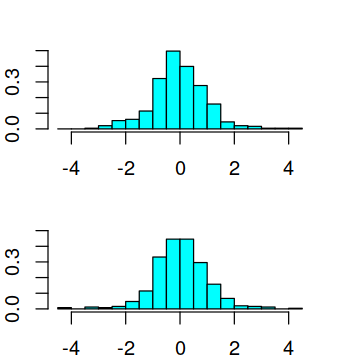

In [27]:
options(repr.plot.width = 3, repr.plot.height = 3)

par(mar = rep(2, 4), mfrow = c(1, 2))
plot(lda.fit)

The prior probabilities of groups mean $\hat\pi_1 = 0.492$ and $\hat\pi_2 = 0.508$, meaning  49.2% of the training observations correspond to days during which the market went down.

Regarding the group means, the average of each predictor within each class distribution, which are used by LDA as estimates of $\mu_k$,
$$ \hat\mu_k = \frac{1}{n_k} \sum_{i:y_i=k} x_i, $$
$$ \hat\sigma^2 = \frac{1}{n-K} \sum_{k=1}^{K} \sum_{i:y_i=k} \left( x_i - \hat\mu_k \right)^2, $$
for $n$  training examples, and $K$ classes.

This suggests that there is a tendency for the previous 2 days’ returns to be negative on days the market increases, and a tendency for the previous 2 day’s returns to be positive on days the market declines.

The *coefficients of linear discriminants* are used in the LDA decision rule. If $-0.642 \times Lag1 - 0.514 \times Lag2$ is large, the prediction is that the market will increase.  The `plot()` function plots the *linear discriminants*, by computing the decision rule of each observation in the train set.

In [28]:
head(data.frame(predict(lda.fit)))

class,posterior.Down,posterior.Up,LD1
Up,0.4950989,0.5049011,-0.14500300
Down,0.5094612,0.4905388,-0.81034228
Down,0.5168756,0.4831244,-1.15402959
Up,0.4947529,0.5052471,-0.12897571
Up,0.4935503,0.5064497,-0.07326231
Down,0.5017058,0.4982942,-0.45104839


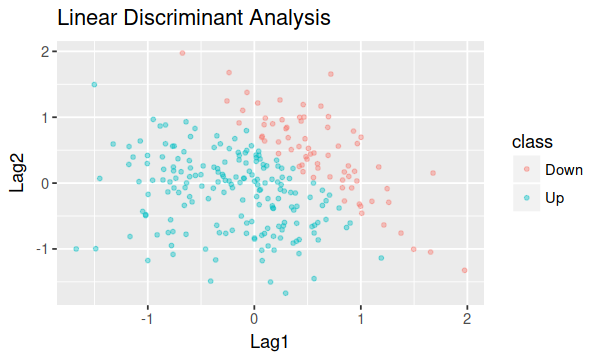

In [29]:
pred <- cbind(
    Smarket.2005[, c("Lag1", "Lag2")],
    class = predict(lda.fit, Smarket.2005)$class
)

options(repr.plot.width = 5, repr.plot.height = 3)
ggplot(pred, aes(Lag1, Lag2, colour = class)) +
    geom_point(alpha = 0.4, size = 1) +
    ggtitle("Linear Discriminant Analysis")

In [30]:
lda.pred <- predict(lda.fit, Smarket.2005)
names(lda.pred)

[1] "class"     "posterior" "x"

The `predict()` function returns a list with three elements:

- **class**: The LDA prediction about the movement of the market.
- **posterior**: A matrix whose *k*th column contains the posterior probability that the corresponding observation belongs to the *k*th class.
- **x**: Contains the linear discriminants.

In [31]:
table(lda.pred$class, Smarket.2005$Direction)

      
       Down  Up
  Down   35  35
  Up     76 106

In [32]:
mean(lda.pred$class == Smarket.2005$Direction)

[1] 0.5595238

In [33]:
sum(lda.pred$posterior[, 1] >= .5)

[1] 70

In [34]:
sum(lda.pred$posterior[, 1] < .5)

[1] 182

In [35]:
lda.pred$posterior[1:20, 1]

999      1000      1001      1002      1003      1004      1005      1006 
0.4901792 0.4792185 0.4668185 0.4740011 0.4927877 0.4938562 0.4951016 0.4872861 
     1007      1008      1009      1010      1011      1012      1013      1014 
0.4907013 0.4844026 0.4906963 0.5119988 0.4895152 0.4706761 0.4744593 0.4799583 
     1015      1016      1017      1018 
0.4935775 0.5030894 0.4978806 0.4886331

In [36]:
lda.pred$class[1:20]

[1] Up   Up   Up   Up   Up   Up   Up   Up   Up   Up   Up   Down Up   Up   Up  
[16] Up   Up   Down Up   Up  
Levels: Down Up

In [37]:
sum(lda.pred$posterior[, 1] > .9)

[1] 0

In [38]:
summary(lda.pred$posterior)

      Down              Up        
 Min.   :0.4578   Min.   :0.4798  
 1st Qu.:0.4847   1st Qu.:0.4994  
 Median :0.4926   Median :0.5074  
 Mean   :0.4923   Mean   :0.5077  
 3rd Qu.:0.5006   3rd Qu.:0.5153  
 Max.   :0.5202   Max.   :0.5422  

No days in 2005 meet the 0.9 threshold. By examining the `max` value in the `summary()` we see that the maximum posterior probability for decrease in 2005 is $0.52$.

### Quadratic Discriminant Analysis

In [39]:
qda.fit <- qda(Direction ~ Lag1 + Lag2, data = Smarket, subset = train)
qda.fit

Call:
qda(Direction ~ Lag1 + Lag2, data = Smarket, subset = train)

Prior probabilities of groups:
    Down       Up 
0.491984 0.508016 

Group means:
            Lag1        Lag2
Down  0.04279022  0.03389409
Up   -0.03954635 -0.03132544

This output does not contain the coefficients of the linear discriminants because the QDA classifier uses a quadratic instead of a linear function of the predictors.

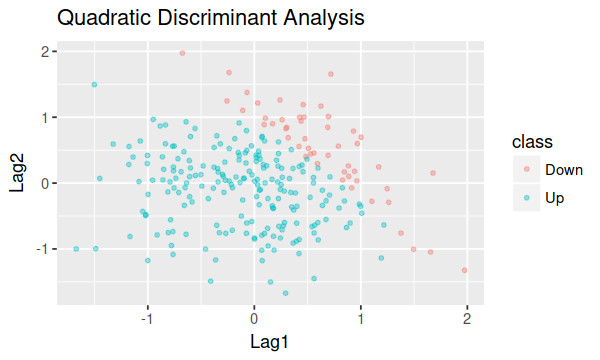

In [40]:
pred <- cbind(
    Smarket.2005[, c("Lag1", "Lag2")],
    class = predict(qda.fit, Smarket.2005)$class
)

options(repr.plot.width = 5, repr.plot.height = 3)
ggplot(pred, aes(Lag1, Lag2, colour = class)) +
    geom_point(alpha = 0.4, size = 1) +
    ggtitle("Quadratic Discriminant Analysis")

In [41]:
qda.class <- predict(qda.fit, Smarket.2005)$class
table(qda.class, Direction.2005)

         Direction.2005
qda.class Down  Up
     Down   30  20
     Up     81 121

In [42]:
mean(qda.class == Direction.2005)

[1] 0.5992063

The QDA predictions are accurate almost 60% of the time. This means the QDA may capture the true relationship more accurately than LDA and logistic regression.

## K-Nearest Neighbors

K-NN is a transduction classifier, which requires four inputs:

1. A matrix of predictors with label,
2. A matrix of predictors without label,
3. The class labels for the first matrix, and
4. A value of $K$, the number of nearest neighbors to be used by the classifier.

In [43]:
train.X <- with(Smarket, cbind(Lag1, Lag2)[train, ])
test.X <- with(Smarket, cbind(Lag1, Lag2)[!train, ])
train.Direction <- Smarket$Direction[train]

In [44]:
set.seed(1)
knn.pred <- knn(train.X, test.X, train.Direction, k = 1)
table(knn.pred, Direction.2005)

        Direction.2005
knn.pred Down Up
    Down   43 58
    Up     68 83

In [45]:
accuracy <- (83 + 43) / 252
accuracy

[1] 0.5

Only 50% of the observations were correctly predicted. Let’s repeat with $K = 3$.

In [46]:
set.seed(1)
knn.pred <- knn(train.X, test.X, train.Direction, k = 3)
table(knn.pred, Direction.2005)

        Direction.2005
knn.pred Down Up
    Down   48 55
    Up     63 86

In [47]:
(48 + 86) / 252

[1] 0.531746

The results have improved slightly. But increasing $K$ further will not improve any further.

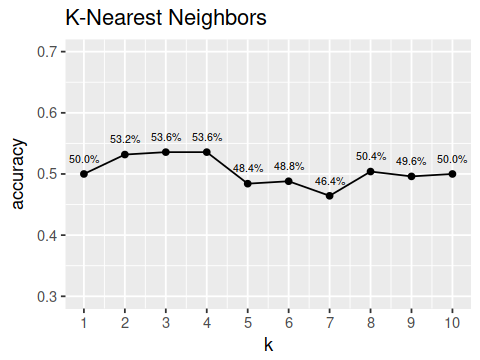

In [48]:
accuracy <- foreach(k = 1:10, .combine = "rbind") %do% {
    knn.pred <- knn(train.X, test.X, train.Direction, k = k)
    acc <- sum(knn.pred == Direction.2005) / length(knn.pred)
    c(k = k, accuracy = acc)
}
accuracy <- data.frame(accuracy)

options(repr.plot.width = 4, repr.plot.height = 3, repr.plot.dpi = 600)
ggplot(accuracy, aes(k, accuracy)) +
    geom_point() +
    geom_line() +
    geom_text(aes(label = sprintf("%.1f%%", 100*accuracy)), size = 2.25, nudge_y = 0.025) +
    scale_y_continuous(limits = c(0.3, 0.7)) +
    scale_x_continuous(breaks = seq(1, 10, 1)) +
    ggtitle("K-Nearest Neighbors")

## An Application to Caravan Insurance Data

Let’s apply the KNN approach to the `Caravan` data set.

In [49]:
dim(Caravan)

[1] 5822   86

In [50]:
head(Caravan)

MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,⋯,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,Purchase
33,1,3,2,8,0,5,1,3,7,⋯,0,0,0,1,0,0,0,0,0,No
37,1,2,2,8,1,4,1,4,6,⋯,0,0,0,1,0,0,0,0,0,No
37,1,2,2,8,0,4,2,4,3,⋯,0,0,0,1,0,0,0,0,0,No
9,1,3,3,3,2,3,2,4,5,⋯,0,0,0,1,0,0,0,0,0,No
40,1,4,2,10,1,4,1,4,7,⋯,0,0,0,1,0,0,0,0,0,No
23,1,2,1,5,0,5,0,5,0,⋯,0,0,0,0,0,0,0,0,0,No


This data set contains 85 predictors that measure demographic characteristics for 5,822 individuals. The response variable is `Purchase`, which indicates whether or not a given individuals purchases a caravan insurance policy. In this data set, only 6% of people purchased caravan insurance.

In [51]:
summary(Caravan$Purchase)

No  Yes 
5474  348

In [52]:
348 / (5474 + 348)

[1] 0.05977327

Because the KNN classifier predicts the class of a given test observation by identifying the observations that are nearest to it, the scale of the variables matters.

In [53]:
standardized.X <- scale(Caravan[, -86])

In [54]:
var(Caravan[, 1])

[1] 165.0378

In [55]:
var(Caravan[, 2])

[1] 0.1647078

In [56]:
var(standardized.X[, 1])

[1] 1

In [57]:
var(standardized.X[, 2])

[1] 1

In [58]:
test <- 1:1000
train.X <- standardized.X[-test, ]
test.X <- standardized.X[test, ]
train.Y <- Caravan$Purchase[-test]
test.Y <- Caravan$Purchase[test]

set.seed(1)
knn.pred <- knn(train.X, test.X, train.Y, k = 1)
mean(test.Y != knn.pred)

[1] 0.118

In [59]:
mean(test.Y != "No")

[1] 0.059

If we always predict `No` the error would be $0.6$ which is less than the current KNN accuracy error of $0.118$.

In [60]:
table(knn.pred, test.Y)

        test.Y
knn.pred  No Yes
     No  873  50
     Yes  68   9

In [61]:
precision <- 9 / (68 + 9)
precision

[1] 0.1168831

Suppose the cost of a salesperson visiting each potential customer is too high. So the overall performance of the model is not of great interest. We are more interested in finding out of all potential customers the KNN suggested, how many actually do purchase insurance. This is the precision of the KNN, which is 11.7%. Let’s build a random guesser and compute this metric:

In [62]:
random.pred <- sample(c("Yes", "No"), nrow(test.X), replace = TRUE)
table(random.pred, test.Y)

           test.Y
random.pred  No Yes
        No  453  28
        Yes 488  31

In [63]:
28 / (497 + 28)

[1] 0.05333333

The random guesser got a precision of 5.3%, meaning KNN is much better in suggesting possible customers.

Indeed, a random binary classifier that outputs 1 with probability $p$ has the following *precision* and *recall*:

$$
\text{Precision} = \frac{\text{TP}}{\text{FP}+\text{TP}}
                 = \frac{p\text{P}}{p\text{N}+p\text{P}}
                 = \frac{\text{P}}{\text{N}+\text{P}},
$$
$$
\text{Recall}    = \frac{\text{TP}}{\text{FN}+\text{TP}}
                 = \frac{p\text{P}}{(1-p)\text{P}+p\text{P}}
                 = p,
$$

In [64]:
set.seed(1)
knn.pred <- knn(train.X, test.X, train.Y, k = 3)
table(knn.pred, test.Y)

        test.Y
knn.pred  No Yes
     No  921  54
     Yes  20   5

In [65]:
mean(test.Y != knn.pred)

[1] 0.074

In [66]:
precision <- 5 / (20 + 5)
precision

[1] 0.2

The precision with $K = 3$ increased from 11.8% to 20%

In [67]:
precision <- function(expected, predicted) {
    TP <- sum((expected == "Yes") & (predicted == "Yes"))
    FP <- sum((expected == "No") & (predicted == "Yes"))
    TP / (TP + FP)
}

recall <- function(expected, predicted) {
    TP <- sum((expected == "Yes") & (predicted == "Yes"))
    FN <- sum((expected == "Yes") & (predicted == "No"))
    TP / (TP + FN)
}

registerDoMC(8)
prec.result <- foreach(k = 1:10, .combine = "rbind") %dopar% {
    set.seed(1)
    knn.pred <- knn(train.X, test.X, train.Y, k = k)
    prec <- precision(test.Y, knn.pred)
    rec <- recall(test.Y, knn.pred)
    c(k = k, precision = prec, recall = rec)
}

Warning message:
“Removed 2 rows containing missing values (geom_point).”Warning message:
“Removed 2 rows containing missing values (geom_path).”Warning message:
“Removed 2 rows containing missing values (geom_text).”

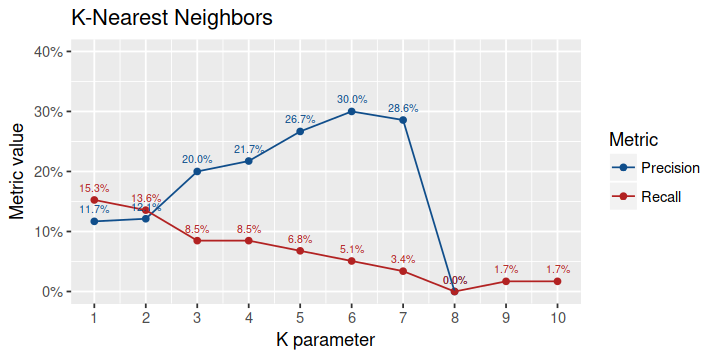

In [68]:
pr.result <- melt(
    data.frame(prec.result), 
    id.vars = c("k"),
    variable.name = "metric"
)

options(repr.plot.width = 6, repr.plot.height = 3, repr.plot.dpi = 600)
ggplot(pr.result, aes(k, value, colour = metric)) +
    geom_point() +
    geom_line() +
    geom_text(aes(label = sprintf("%.1f%%", 100 * value)), 
              size = 2.25, nudge_y = 0.02) +
    scale_x_continuous(breaks = seq(1, 10, 1)) +
    scale_y_continuous(limit = c(0, 0.4), labels = scales::percent) +
    scale_colour_manual(labels = c("Precision", "Recall"), 
                        values = c("dodgerblue4", "firebrick")) +
    guides(colour = guide_legend("Metric")) +
    xlab("K parameter") +
    ylab("Metric value") +
    ggtitle("K-Nearest Neighbors")

With $K = 6$ we have a precision of 30% at the cost of getting only 5.1% of the puchases.

We can also compare with a logistic regression. But instead of using a threshold of 0.5 for decision of purchase or not, we will use 0.25.

In [69]:
glm.fits <- glm(Purchase ~ ., data = Caravan,
                family = binomial, subset = -test)
glm.probs <- predict(glm.fits, Caravan[test, ], type = "response")
glm.pred <- rep("No", 1000)
glm.pred[glm.probs > .5] <- "Yes"
table(glm.pred, test.Y)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

        test.Y
glm.pred  No Yes
     No  934  59
     Yes   7   0

In [70]:
glm.pred[glm.probs > .25] <- "Yes"
table(glm.pred, test.Y)

        test.Y
glm.pred  No Yes
     No  919  48
     Yes  22  11

In [71]:
precision(test.Y, glm.pred)

[1] 0.3333333

In [72]:
recall(test.Y, glm.pred)

[1] 0.1864407

We got a precision of 33.3% and a recall of 18.6%. As comparison, our K-NN with the highest precision is $K = 6$, precision of 30% and recall of 6.1%. Thus, the logistic regression is better in both precision and recall metrics.

# Exercises

### Conceptual

1. Using a little bit of algebra, prove that (4.2) is equivalent to (4.3). In other words, the logistic function representation and logit representation for the logistic regression model are equivalent.

$$
p(X) = \frac{e^{\beta_0 + \beta_1 X}}{{1+e^{\beta_0 + \beta_1 X}}} \; (4.2)
$$

$$
\frac{p(X)}{1-p(X)}  =\frac{e^{\beta_0 + \beta_1 X}}{{1+e^{\beta_0 + \beta_1 X}}} \; (4.3)
$$

*Answer:*

Let $A = e^{\beta_0 + \beta_1 X}$.
$$
p(X) = \frac{A}{1+A}.
$$
Pluging into (4.3):
$$
\frac{p(X)}{1-p(X)} = \frac{\frac{A}{1+A}}{1-\frac{A}{1+A}} = \frac{\frac{A}{1+A}}{\frac{(1+A)-A}{1+A}} = \frac{A}{1+A} (1+A) = A = e^{\beta_0 + \beta_1 X}
$$


### Applied

### Exercise 10

Questions with the **Weekly** dataset. This dataset is similar in nature to the **Smarket** (S&P Stock Market), except that is contains 1,089 weekly returns for 21 years, from the beginning of 1990 to the end of 2010.

a) Produce some numerical and graphical summaries of the **Weekly** data. Do there appear to be any patterns?

Description: Weekly percentage returns for the S&P 500 stock index between 1990 and 2010.

A data frame with 1089 observations on the following 9 variables.

Variable | Description
:- | :-
Year | The year that the observation was recorded
Lag1 | Percentage return for previous week
Lag2 | Percentage return for 2 weeks previous
Lag3 | Percentage return for 3 weeks previous
Lag4 | Percentage return for 4 weeks previous
Lag5 | Percentage return for 5 weeks previous
Volume | Volume of shares traded (average number of daily shares traded in billions)
Today | Percentage return for this week
Direction | A factor with levels Down and Up indicating whether the market had a positive or negative return on a given week


In [73]:
head(Weekly)

Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
1990,0.816,1.572,-3.936,-0.229,-3.484,0.1549760,-0.270,Down
1990,-0.270,0.816,1.572,-3.936,-0.229,0.1485740,-2.576,Down
1990,-2.576,-0.270,0.816,1.572,-3.936,0.1598375,3.514,Up
1990,3.514,-2.576,-0.270,0.816,1.572,0.1616300,0.712,Up
1990,0.712,3.514,-2.576,-0.270,0.816,0.1537280,1.178,Up
1990,1.178,0.712,3.514,-2.576,-0.270,0.1544440,-1.372,Down


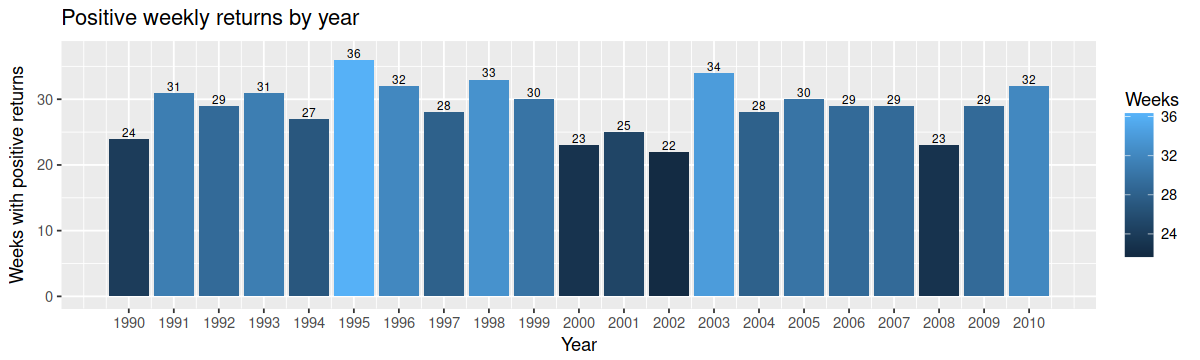

In [74]:
by_year <- Weekly %>%
    group_by(Year) %>%
    summarise(
        Up = sum(Direction == "Up")) %>% 
    melt(id.vars = "Year",
         variable.name = "Direction",
         value.name = "Weeks")

options(repr.plot.width = 10, repr.plot.height = 3)
ggplot(by_year, aes(Year, Weeks, fill = Weeks)) +
    geom_bar(stat = "identity", position = "dodge") +
    geom_text(stat = "identity", aes(label = Weeks), nudge_y = 1, size = 2.5) +
    scale_x_continuous(breaks = seq(1990, 2010, 1)) +
    ylab("Weeks with positive returns") +
    ggtitle("Positive weekly returns by year")

There does not seem to have a tendency over the years. If any, perhaps in cycles.

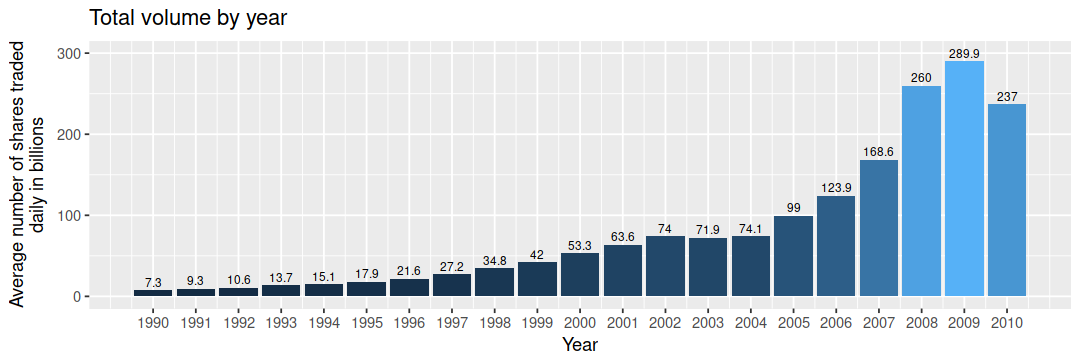

In [75]:
by_year <- Weekly %>%
    group_by(Year) %>%
    summarise(TotalVolume = sum(Volume))

options(repr.plot.width = 9, repr.plot.height = 3)
ggplot(by_year, aes(Year, TotalVolume, fill = TotalVolume)) +
    geom_bar(stat = "identity") +
    geom_text(stat = "identity", aes(label = round(TotalVolume, 1)), nudge_y = 10, size = 2.5) +
    scale_x_continuous(breaks = seq(1990, 2010, 1)) +
    guides(fill = FALSE) +
    ylab("Average number of shares traded\ndaily in billions") +
    ggtitle("Total volume by year")

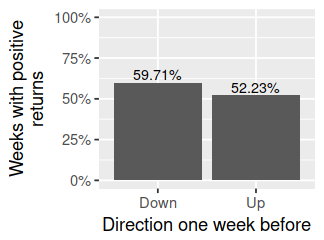

In [76]:
last_day <- Weekly
last_day$Direction1 <- c("Down", "Up")[as.integer(last_day$Lag1 > 0) + 1]

last_day <- last_day %>%
    group_by(Direction1) %>%
    summarise(Up = sum(Direction == "Up") / n()) %>%
    melt(id.vars = "Direction1", variable.name = "Direction", value.name = "Weeks")

options(repr.plot.width = 2.7, repr.plot.height = 2)
ggplot(last_day, aes(Direction1, Weeks)) +
    geom_bar(stat = "identity", position = "dodge") +
    geom_text(aes(label = scales::percent(Weeks)), nudge_y = 0.05, size = 3) +
    scale_y_continuous(limit = c(0, 1), labels = scales::percent) +
    xlab("Direction one week before") +
    ylab("Weeks with positive\nreturns")

The same pattern as we saw in **Smarket** appears here. In all weeks with positive returns, 59.71% dos the weeks before had negative returns.

So yes, there appear to have some patterns.

b) Use the full data set to perform a logistic regression with **Direction** as the response variable and the five lag variables plus **Volume** as predictors. Use the summary function to print the results. Do any of the predictors appear to be statistically significant? If so, which ones?

In [77]:
glm.fits <- glm(Direction ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + Volume,
                data = Weekly, family = binomial)
summary(glm.fits)


Call:
glm(formula = Direction ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + 
    Volume, family = binomial, data = Weekly)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6949  -1.2565   0.9913   1.0849   1.4579  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)   
(Intercept)  0.26686    0.08593   3.106   0.0019 **
Lag1        -0.04127    0.02641  -1.563   0.1181   
Lag2         0.05844    0.02686   2.175   0.0296 * 
Lag3        -0.01606    0.02666  -0.602   0.5469   
Lag4        -0.02779    0.02646  -1.050   0.2937   
Lag5        -0.01447    0.02638  -0.549   0.5833   
Volume      -0.02274    0.03690  -0.616   0.5377   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1496.2  on 1088  degrees of freedom
Residual deviance: 1486.4  on 1082  degrees of freedom
AIC: 1500.4

Number of Fisher Scoring iterations: 4


Only **Lag2** seems to be relevant, with a p-value of 0.022. On the train subset, not even the intercept seems statistically significant at a level of 5%.

c) Compute the confusion matrix and overall fraction of correct predictions. Explain what the confusion matrix is telling you about the types of mistakes made by logistic regression.

In [78]:
glm.pred <- predict.glm(glm.fits, Weekly, type = "response")
glm.class <- rep("Down", nrow(Weekly))
glm.class[glm.pred > 0.5] <- "Up"

table(glm.class, Weekly$Direction)

         
glm.class Down  Up
     Down   54  48
     Up    430 557

In [79]:
accuracy <- sum(glm.class == Weekly$Direction) / length(glm.class)
accuracy

[1] 0.5610652

For reference, let’s see how much accuracy a random guesser would get.

In [80]:
table(Weekly$Direction) / nrow(Weekly)


     Down        Up 
0.4444444 0.5555556 

So a random guesser can get about 55.6% of accuracy while our logistic regression got only 56.1%

d) Now fit a logistic regresssion model using a training data period from 1990 to 2008, with **Lag2** as the only predictor. Compute the confusion matrix and the overall fraction of correct predictions for the held out data (that is, the data from 2009 and 2010).

In [81]:
train <- Weekly$Year <= 2009

Let’s first make the same model with the **Lag** features and **Volume**.

In [82]:
glm.fit.bl <- glm(
    Direction ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + Volume,
    data = Weekly, family = binomial)
summary(glm.fit.bl)


Call:
glm(formula = Direction ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + 
    Volume, family = binomial, data = Weekly)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6949  -1.2565   0.9913   1.0849   1.4579  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)   
(Intercept)  0.26686    0.08593   3.106   0.0019 **
Lag1        -0.04127    0.02641  -1.563   0.1181   
Lag2         0.05844    0.02686   2.175   0.0296 * 
Lag3        -0.01606    0.02666  -0.602   0.5469   
Lag4        -0.02779    0.02646  -1.050   0.2937   
Lag5        -0.01447    0.02638  -0.549   0.5833   
Volume      -0.02274    0.03690  -0.616   0.5377   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1496.2  on 1088  degrees of freedom
Residual deviance: 1486.4  on 1082  degrees of freedom
AIC: 1500.4

Number of Fisher Scoring iterations: 4


In [83]:
glm.pred <- predict(glm.fit.bl, subset(Weekly, !train),
                    type = "response")
glm.class <- rep("Down", sum(!train))
glm.class[glm.pred > 0.5] <- "Up"

table(glm.class, subset(Weekly, !train)$Direction)

         
glm.class Down Up
     Down    9  2
     Up     11 30

In [84]:
accuracy <- (9 + 30) / sum(!train)
accuracy

[1] 0.75

So our accuracy is 75% here. Let’s finally do what the exercise tells us to do.

In [85]:
glm.fits <- glm(Direction ~ Lag2, family = binomial,
                data = Weekly, subset = train)
summary(glm.fits)


Call:
glm(formula = Direction ~ Lag2, family = binomial, data = Weekly, 
    subset = train)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.507  -1.264   1.026   1.091   1.338  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)   
(Intercept)  0.20416    0.06265   3.259  0.00112 **
Lag2         0.05188    0.02688   1.930  0.05359 . 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1426.1  on 1036  degrees of freedom
Residual deviance: 1422.3  on 1035  degrees of freedom
AIC: 1426.3

Number of Fisher Scoring iterations: 4


In [86]:
glm.pred <- predict(glm.fits, subset(Weekly, !train),
                    type = "response")
glm.class <- rep("Down", sum(!train))
glm.class[glm.pred > 0.5] <- "Up"

table(glm.class, subset(Weekly, !train)$Direction)

         
glm.class Down Up
     Down    3  0
     Up     17 32

In [87]:
accuracy <- (3 + 32) / sum(!train)
precision <- 32 / (17 + 32)
recall <- 32 / (32 + 0)
c(accuracy = accuracy, recall = recall, precision = precision)

accuracy    recall precision 
0.6730769 1.0000000 0.6530612

With only one predictor, our accuracy has decreased from 75% to 67.3%.

e) Repeat (d) using LDA.

In [88]:
lda.fit <- lda(Direction ~ Lag2, data = Weekly, subset = train)
lda.fit

Call:
lda(Direction ~ Lag2, data = Weekly, subset = train)

Prior probabilities of groups:
     Down        Up 
0.4474446 0.5525554 

Group means:
            Lag2
Down -0.01205819
Up    0.27317277

Coefficients of linear discriminants:
           LD1
Lag2 0.4251927

The prior probabilities of groups mean $\hat\pi_1 = 0.448$ and $\hat\pi_2 = 0.553$, meaning 44.8% of the training observations correspond to weeks that ended with a decreasing market.

Regarding the group means, the average of each predictor within each class distribution, which are used by LDA as estimates of $\mu_k$,
$$ \hat\mu_k = \frac{1}{n_k} \sum_{i:y_i=k} x_i, $$
$$ \hat\sigma^2 = \frac{1}{n-K} \sum_{k=1}^{K} \sum_{i:y_i=k} \left( x_i - \hat\mu_k \right)^2, $$
for $n$  training examples, and $K$ classes.

In [89]:
lda.pred <- predict(lda.fit, subset(Weekly, !train))
lda.class <- rep("Down", sum(!train))
lda.class[glm.pred > 0.5] <- "Up"

table(lda.class, subset(Weekly, !train)$Direction)

         
lda.class Down Up
     Down    3  0
     Up     17 32

In [90]:
accuracy <- (3 + 32) / sum(!train)
precision <- 32 / (17 + 32)
recall <- 32 / (32 + 0)
c(accuracy = accuracy, recall = recall, precision = precision)

accuracy    recall precision 
0.6730769 1.0000000 0.6530612

LDA and Logistic Regression are equal:

Metric    | Logistic Regression | LDA
:-------- | :------------------ | :---
Accuracy  | 67.3%               | 67.3%
Recall    | 100%                | 100%
Precision | 65.3%               | 65.3% 

f) Repeat (d) using QDA.

In [91]:
qda.fit <- qda(Direction ~ Lag2, data = Weekly, subset = train)
qda.fit

Call:
qda(Direction ~ Lag2, data = Weekly, subset = train)

Prior probabilities of groups:
     Down        Up 
0.4474446 0.5525554 

Group means:
            Lag2
Down -0.01205819
Up    0.27317277

In [92]:
qda.pred <- predict(qda.fit, subset(Weekly, !train))
qda.class <- rep("Down", sum(!train))
qda.class[glm.pred > 0.5] <- "Up"

table(qda.class, subset(Weekly, !train)$Direction)

         
qda.class Down Up
     Down    3  0
     Up     17 32

In [93]:
accuracy <- (3 + 32) / sum(!train)
precision <- 32 / (17 + 32)
recall <- 32 / (32 + 0)
c(accuracy = accuracy, recall = recall, precision = precision)

accuracy    recall precision 
0.6730769 1.0000000 0.6530612

QDA didn’t improve on accuracy nor in precision or recall.

g) Repeat (d) using KNN with $K = 1$.

In [94]:
X.train <- subset(Weekly, train)["Lag2"]
X.test <- subset(Weekly, !train)["Lag2"]
y.train <- subset(Weekly, train)$Direction
y.test <- subset(Weekly, !train)$Direction

knn.class <- knn(X.train, X.test, y.train, k = 1)

table(knn.class, subset(Weekly, !train)$Direction)

         
knn.class Down Up
     Down    8 15
     Up     12 17

In [95]:
accuracy <- (8 + 17) / sum(!train)
precision <- 17 / (12 + 17)
recall <- 17 / (15 + 17)
c(accuracy = accuracy, recall = recall, precision = precision)

accuracy    recall precision 
0.4807692 0.5312500 0.5862069

1-NN has a lower accuracy, recall and precision than the others:

Metric    | Logistic Regression | LDA   | 1-NN
:-------- | :------------------ | :---- | :---
Accuracy  | 67.3%               | 67.3% | 48.1%
Recall    | 100%                | 100%  | 53.1%
Precision | 65.3%               | 65.3% | 58.6%

h) Which of these methods appears to provide the best results on this data?

By considering only the overall accuracy, LDA achieves the highest accuracy rate. However, if the model’s precision is very important, then a logistic regression could suffice due it’s 100% recall at cost of a lower precision, compared with LDA. But it’s important to note that we used a cut of 0.5 for the decision making. We could have tuned it to get the desired precision–recall trade-off — this would not be possible with this current KNN implementation.

i) Experiment with different combinations of predictors, including possible transformations and interactions, for each of the methods. Report the variables, method, and associated confusion matrix that appears to provide the best results on the held out data. Note that you should also experiment with values for $K$ in the KNN classifier.

##### Logistic Regression

In [96]:
evaluate <- function(predicted, expected) {
    TN <- sum((expected == "Down") & (predicted == "Down"))
    TP <- sum((expected == "Up") & (predicted == "Up"))
    FP <- sum((expected == "Down") & (predicted == "Up"))
    FN <- sum((expected == "Up") & (predicted == "Down"))
    data.frame(
        accuracy  = (TP + TN) / length(expected),
        precision = TP / (FP + TP),
        recall    = TP / (FN + TP)
    )
}

bin.predict <- function(model, newdata, cut = 0.5) {
    pred <- predict(model, newdata = newdata)
    resp <- rep("Down", length(pred))
    resp[pred > cut] <- "Up"
    resp
}

In [97]:
X <- subset(Weekly, select = -c(Year, Today))
            
glm.fit <- glm(Direction ~ .^2, family = binomial,
               data = X, subset = train)
summary(glm.fit)


Call:
glm(formula = Direction ~ .^2, family = binomial, data = X, subset = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5998  -1.2524   0.9499   1.0826   2.0757  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)   
(Intercept)  0.2911836  0.0887309   3.282  0.00103 **
Lag1        -0.0429702  0.0403502  -1.065  0.28691   
Lag2         0.0378872  0.0407496   0.930  0.35250   
Lag3        -0.0243726  0.0417466  -0.584  0.55934   
Lag4        -0.0324394  0.0417184  -0.778  0.43682   
Lag5        -0.0743486  0.0419225  -1.773  0.07615 . 
Volume      -0.0408153  0.0421559  -0.968  0.33295   
Lag1:Lag2    0.0029159  0.0087940   0.332  0.74020   
Lag1:Lag3    0.0107410  0.0095896   1.120  0.26269   
Lag1:Lag4   -0.0111930  0.0093177  -1.201  0.22965   
Lag1:Lag5   -0.0192881  0.0104487  -1.846  0.06489 . 
Lag1:Volume  0.0031401  0.0132541   0.237  0.81272   
Lag2:Lag3    0.0042103  0.0087545   0.481  0.63056   
Lag2:Lag4   -0.0053992  0.009725

**Lag5**, **Lag1:Lag5**, **Lag3:Lag4**, and **Lag5:Volume** seem to have some relevance.

In [98]:
find.best.cut <- function(model, data) {
    # Find the cut that maximizes the accuracy.
    pred <- predict(model, newdata = data, type = "response")
    no <- rep("No", length(pred))
    cuts <- unique(pred)
    
    acc <- foreach(cut = cuts) %do% {
        class <- no
        class[pred > cut] <- "Up"
        mean(class == data$Direction)
    }
    
    cuts[which.max(acc)]
}

Let’s find the best cut looking at the training data.

In [99]:
cut <- find.best.cut(glm.fit, subset(Weekly, train))
cut

[1] 0.1159869

In [100]:
X.test <- subset(Weekly, !train)
pred <- bin.predict(glm.fit, X.test, cut)
print(table(pred, X.test$Direction))
round(evaluate(pred, X.test$Direction), 4)

      
pred   Down Up
  Down   11  9
  Up      9 23


accuracy,precision,recall
0.6538,0.7188,0.7188


In [101]:
X <- subset(Weekly, select = -c(Year, Today))
            
glm.fit <- glm(Direction ~ Lag2 + Lag1*Lag5 + Lag3*Lag4 + Lag5*Volume, family = binomial,
               data = X, subset = train)
summary(glm.fit)


Call:
glm(formula = Direction ~ Lag2 + Lag1 * Lag5 + Lag3 * Lag4 + 
    Lag5 * Volume, family = binomial, data = X, subset = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5576  -1.2542   0.9697   1.0828   2.1589  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)   
(Intercept)  0.282628   0.087451   3.232  0.00123 **
Lag2         0.048878   0.027769   1.760  0.07838 . 
Lag1        -0.041478   0.027576  -1.504  0.13255   
Lag5        -0.078276   0.040153  -1.949  0.05124 . 
Lag3        -0.002345   0.029259  -0.080  0.93612   
Lag4        -0.029351   0.028337  -1.036  0.30029   
Volume      -0.035133   0.041329  -0.850  0.39528   
Lag1:Lag5   -0.013952   0.008863  -1.574  0.11544   
Lag3:Lag4    0.011089   0.007544   1.470  0.14161   
Lag5:Volume  0.025736   0.013065   1.970  0.04885 * 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1426.1  on

In [102]:
cut <- find.best.cut(glm.fit, subset(Weekly, train))
cut

[1] 0.1494111

In [103]:
X.test <- subset(Weekly, !train)
pred <- bin.predict(glm.fit, X.test, cut)
print(table(pred, X.test$Direction))
round(evaluate(pred, X.test$Direction), 4)

      
pred   Down Up
  Down   14 17
  Up      6 15


accuracy,precision,recall
0.5577,0.7143,0.4688


Let’s also try with only the interaction **a:b** instead of **a*b**.m

In [104]:
X <- subset(Weekly, select = -c(Year, Today))
            
glm.fit <- glm(Direction ~ Lag2 + Lag5 + Lag1:Lag5 + Lag3:Lag4 + Lag5:Volume, family = binomial,
               data = X, subset = train)
summary(glm.fit)


Call:
glm(formula = Direction ~ Lag2 + Lag5 + Lag1:Lag5 + Lag3:Lag4 + 
    Lag5:Volume, family = binomial, data = X, subset = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.4979  -1.2559   0.9919   1.0866   2.1237  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.220237   0.063369   3.475  0.00051 ***
Lag2         0.052449   0.027351   1.918  0.05516 .  
Lag5        -0.074302   0.039928  -1.861  0.06276 .  
Lag5:Lag1   -0.014365   0.008517  -1.687  0.09168 .  
Lag3:Lag4    0.010373   0.006915   1.500  0.13357    
Lag5:Volume  0.026127   0.013018   2.007  0.04476 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1426.1  on 1036  degrees of freedom
Residual deviance: 1412.6  on 1031  degrees of freedom
AIC: 1424.6

Number of Fisher Scoring iterations: 4


In [105]:
cut <- find.best.cut(glm.fit, subset(Weekly, train))
X.test <- subset(Weekly, !train)
pred <- bin.predict(glm.fit, X.test, cut)
print(table(pred, X.test$Direction))
round(evaluate(pred, X.test$Direction), 4)

      
pred   Down Up
  Down    7  5
  Up     13 27


accuracy,precision,recall
0.6538,0.675,0.8438


Much better for our logistic regression. Let’s see if we can find some interesting transformation.

In [106]:
X <- subset(Weekly, select = -c(Year, Today))
            
glm.fit <- glm(Direction ~ polym(Lag1, Lag2, degree = 3),
               family = binomial, data = X, subset = train)
summary(glm.fit)


Call:
glm(formula = Direction ~ polym(Lag1, Lag2, degree = 3), family = binomial, 
    data = X, subset = train)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.729  -1.253   1.019   1.094   1.461  

Coefficients:
                                  Estimate Std. Error z value Pr(>|z|)   
(Intercept)                        0.20893    0.06413   3.258  0.00112 **
polym(Lag1, Lag2, degree = 3)1.0  -5.47031    3.10223  -1.763  0.07784 . 
polym(Lag1, Lag2, degree = 3)2.0   2.25734    4.69078   0.481  0.63035   
polym(Lag1, Lag2, degree = 3)3.0  -6.34959    4.64242  -1.368  0.17140   
polym(Lag1, Lag2, degree = 3)0.1   6.84744    2.73802   2.501  0.01239 * 
polym(Lag1, Lag2, degree = 3)1.1  -0.06569   61.83262  -0.001  0.99915   
polym(Lag1, Lag2, degree = 3)2.1 -27.10800   52.27554  -0.519  0.60407   
polym(Lag1, Lag2, degree = 3)0.2  -0.83785    3.29817  -0.254  0.79947   
polym(Lag1, Lag2, degree = 3)1.2 135.76125   81.88974   1.658  0.09735 . 
polym(Lag1, Lag2, degree = 

Let’s revisit our best model so far.

In [107]:
X <- subset(Weekly, select = -c(Year, Today))
            
glm.fit <- glm(Direction ~ Lag2 + Lag5 + Lag1:Lag5 + Lag3:Lag4 + Lag5:Volume,
               family = binomial, data = X, subset = train)
summary(glm.fit)
cut <- find.best.cut(glm.fit, subset(Weekly, train))
X.test <- subset(Weekly, !train)
pred <- bin.predict(glm.fit, X.test, cut)
print(table(pred, X.test$Direction))
round(evaluate(pred, X.test$Direction), 4)


Call:
glm(formula = Direction ~ Lag2 + Lag5 + Lag1:Lag5 + Lag3:Lag4 + 
    Lag5:Volume, family = binomial, data = X, subset = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.4979  -1.2559   0.9919   1.0866   2.1237  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.220237   0.063369   3.475  0.00051 ***
Lag2         0.052449   0.027351   1.918  0.05516 .  
Lag5        -0.074302   0.039928  -1.861  0.06276 .  
Lag5:Lag1   -0.014365   0.008517  -1.687  0.09168 .  
Lag3:Lag4    0.010373   0.006915   1.500  0.13357    
Lag5:Volume  0.026127   0.013018   2.007  0.04476 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1426.1  on 1036  degrees of freedom
Residual deviance: 1412.6  on 1031  degrees of freedom
AIC: 1424.6

Number of Fisher Scoring iterations: 4


      
pred   Down Up
  Down    7  5
  Up     13 27


accuracy,precision,recall
0.6538,0.675,0.8438


Now let’s try the power of **Volume**.

In [108]:
X <- subset(Weekly, select = -c(Year, Today))
            
glm.fit <- glm(Direction ~ Lag2 + Lag5 + Lag1:Lag5 + Lag3:Lag4 + Lag5:I(Volume^2),
               family = binomial, data = X, subset = train)
summary(glm.fit)
cut <- find.best.cut(glm.fit, subset(Weekly, train))
X.test <- subset(Weekly, !train)
pred <- bin.predict(glm.fit, X.test, cut)
print(table(pred, X.test$Direction))
round(evaluate(pred, X.test$Direction), 4)


Call:
glm(formula = Direction ~ Lag2 + Lag5 + Lag1:Lag5 + Lag3:Lag4 + 
    Lag5:I(Volume^2), family = binomial, data = X, subset = train)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.489  -1.257   1.001   1.086   2.137  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)       0.218371   0.063316   3.449 0.000563 ***
Lag2              0.051849   0.027314   1.898 0.057659 .  
Lag5             -0.045955   0.032937  -1.395 0.162940    
Lag5:Lag1        -0.014206   0.008485  -1.674 0.094070 .  
Lag3:Lag4         0.010569   0.006933   1.524 0.127389    
Lag5:I(Volume^2)  0.003123   0.001866   1.674 0.094114 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1426.1  on 1036  degrees of freedom
Residual deviance: 1413.9  on 1031  degrees of freedom
AIC: 1425.9

Number of Fisher Scoring iterations: 4


      
pred   Down Up
  Down   10  7
  Up     10 25


accuracy,precision,recall
0.6731,0.7143,0.7812


Accuracy on the test set increased from 65.4% to 67.3%, and the precision from 67.5% to 71.4%, whereas our recall decreased from 84.4% to 78.1%.

Metric    | Logistic Regression | LDA   | 1-NN   | Logistic Regression 2
:-------- | :------------------ | :---- | :----- | :--------------------
Accuracy  | 67.3%               | 67.3% | 48.1%  | 67.3%
Recall    | 100%                | 100%  | 53.1%  | 71.4%
Precision | 65.3%               | 65.3% | 58.6%  | 78.1%

Thus, I could not improve the logistic regression, except for the fact I managed to play with the precision–recall trade-off without affecting the accuracy.

##### Linear Discriminant Analysis

In [109]:
find.best.cut <- function(predicted, expected) {
    # Find the cut that maximizes the accuracy.
    no <- rep("No", length(predicted))
    cuts <- unique(predicted)
    
    acc <- foreach(cut = cuts) %do% {
        class <- no
        class[predicted > cut] <- "Up"
        mean(class == expected)
    }
    
    cuts[which.max(acc)]
}

bin.predict <- function(model, newdata, cut = 0.5) {
    # Binarize LDA prediction
    pred <- as.numeric(predict(model, newdata)$posterior[, "Up"])
    resp <- rep("Down", length(pred))
    resp[pred > cut] <- "Up"
    resp
}

In [110]:
X <- subset(Weekly, select = -c(Year, Today))
X.train <- subset(Weekly, train)
X.test <- subset(Weekly, !train)

lda.fit <- lda(Direction ~ ., family = binomial,
               data = X, subset = train)

evaluate(predict(lda.fit, X.test)$class, X.test$Direction)

accuracy,precision,recall
0.6923077,0.7105263,0.84375


In [111]:
table(predict(lda.fit, X.test)$class, X.test$Direction)

      
       Down Up
  Down    9  5
  Up     11 27

Let’s see what we get from choosing our own cut.

In [112]:
pred <- as.numeric(predict(lda.fit, X.train)$posterior[, "Up"])
cut <- find.best.cut(pred, X.train$Direction)
lda.class <- bin.predict(lda.fit, X.test, cut)
evaluate(lda.class, X.test$Direction)

accuracy,precision,recall
0.6153846,0.6153846,1


In [113]:
table(lda.class, X.test$Direction)

         
lda.class Down Up
       Up   20 32

Our `find.best.cut` made a poor choice for cut, since the model is predicting only **Up** values.

Let’s see if using the best features for logistic regression will lead us to a better performance with LDA.

In [114]:
lda.fit <- lda(Direction ~ Lag2 + Lag5 + Lag1:Lag5 + Lag3:Lag4 + Lag5:I(Volume^2),
               data = X, subset = train)

pred <- predict(lda.fit, X.test)$class
print(table(pred, X.test$Direction))
round(evaluate(pred, X.test$Direction), 4)

      
pred   Down Up
  Down    4  2
  Up     16 30


accuracy,precision,recall
0.6538,0.6522,0.9375


It got better. But let’s try changing some features.

In [115]:
lda.fit <- lda(Direction ~ Lag2 + Lag5 + Lag1:Lag5 + Lag3:Lag4 + Lag5:Volume,
               data = X, subset = train)

pred <- predict(lda.fit, X.test)$class
print(table(pred, X.test$Direction))
round(evaluate(pred, X.test$Direction), 4)

      
pred   Down Up
  Down    5  2
  Up     15 30


accuracy,precision,recall
0.6731,0.6667,0.9375


In [116]:
lda.fit <- lda(Direction ~ Lag2 + Lag5 + Lag1:Lag5 + Lag3:Lag4 + Lag5:Volume,
               data = X, subset = train)

pred <- predict(lda.fit, X.test)$class
print(table(pred, X.test$Direction))
round(evaluate(pred, X.test$Direction), 4)

      
pred   Down Up
  Down    5  2
  Up     15 30


accuracy,precision,recall
0.6731,0.6667,0.9375


Still not better than the simpler models. I tried adding all features and adding single interactions, until I reach this model:

In [117]:
X <- subset(Weekly, select = -c(Year, Today))
X.train <- subset(Weekly, train)
X.test <- subset(Weekly, !train)

lda.fit <- lda(Direction ~ .+ Lag5:Volume, family = binomial,
               data = X, subset = train)

evaluate(predict(lda.fit, X.test)$class, X.test$Direction)

accuracy,precision,recall
0.7307692,0.725,0.90625


Metric    | Logistic Regression | LDA   | 1-NN   | Logistic Regression 2 | LDA 2
:-------- | :------------------ | :---- | :----- | :-------------------- | :----
Accuracy  | 67.3%               | 67.3% | 48.1%  | 67.3%                 | 73.1%
Recall    | 100%                | 100%  | 53.1%  | 71.4%                 | 72.5%
Precision | 65.3%               | 65.3% | 58.6%  | 78.1%                 | 90.6%

The improved LDA has actually increased the accuracy metric, with a bit of trade-off of precision–recall.

##### K-Nearest Neighbors

In [118]:
precision <- function(expected, predicted) {
    TP <- sum((expected == "Up") & (predicted == "Up"))
    FP <- sum((expected == "Down") & (predicted == "Up"))
    TP / (TP + FP)
}

recall <- function(expected, predicted) {
    TP <- sum((expected == "Up") & (predicted == "Up"))
    FN <- sum((expected == "Up") & (predicted == "Down"))
    TP / (TP + FN)
}

We need to put all features in the same scale of mean 0 and variance 1 to avoid one feature dominating other when computing the euclidean distance.

In [119]:
registerDoMC(8)

plot.knn <- function() {
    prec.result <- foreach(k = 1:10, .combine = "rbind") %dopar% {
        set.seed(1)
        knn.pred <- knn(X.train, X.test, y.train, k = k)
        prec <- precision(y.test, knn.pred)
        rec <- recall(y.test, knn.pred)
        acc <- mean(y.test == knn.pred)
        c(k = k, precision = prec, recall = rec, accuracy = acc)
    }

    pr.result <- melt(
        data.frame(prec.result), 
        id.vars = c("k"),
        variable.name = "metric"
    )

    options(repr.plot.width = 6, repr.plot.height = 3, repr.plot.dpi = 600)
    ggplot(pr.result, aes(k, value, colour = metric)) +
        geom_point() +
        geom_line() +
        geom_text(aes(label = sprintf("%.1f%%", 100 * value)), 
                  size = 2.25, nudge_y = 0.015) +
        scale_x_continuous(breaks = seq(1, 10, 1)) +
        #scale_y_continuous(limit = c(0.4, 0.7), labels = scales::percent) +
        scale_colour_manual(labels = c("Precision", "Recall", "Accuracy"), 
                            values = c("dodgerblue4", "firebrick", "darkgoldenrod3")) +
        guides(colour = guide_legend("Metric")) +
        xlab("K parameter") +
        ylab("Metric value") +
        ggtitle("K-Nearest Neighbors")
}


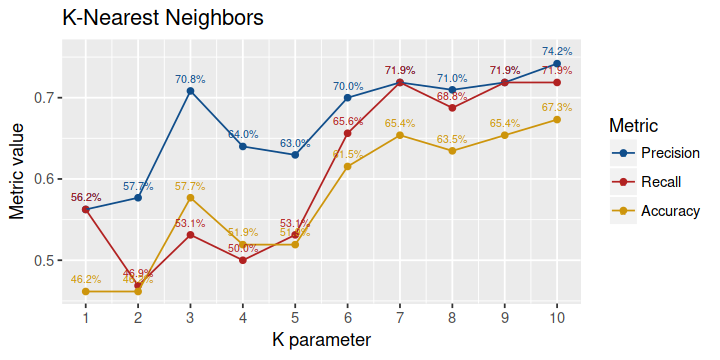

In [120]:
base <- Weekly
base$Lag1Lag5 <- with(base, Lag1 / Lag5)
base$AvgLag <- with(base, (Lag1 + Lag2) / 2)
X <- scale(subset(base, select = c(AvgLag)))
#X <- scale(subset(base, select = c(Lag1, Lag2, Lag5, Lag1Lag5)))
X.train <- subset(X, train)
X.test <- subset(X, !train)
y.train <- subset(Weekly, train)$Direction
y.test <- subset(Weekly, !train)$Direction

plot.knn()

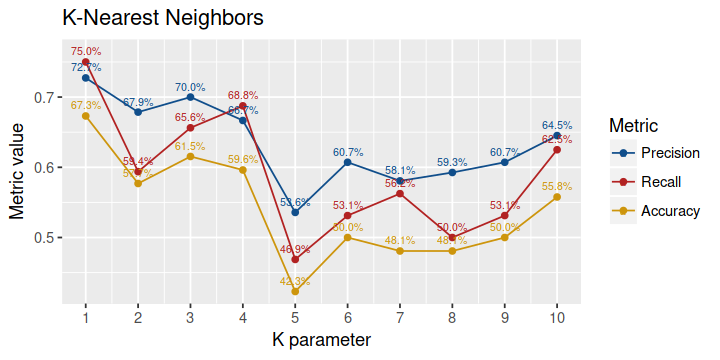

In [121]:
base <- Weekly
base$Lag1Lag5 <- with(base, Lag1 / Lag5)
base$AvgLag <- with(base, (Lag1 + Lag2) / 2)
X <- scale(subset(base, select = c(Lag1, Lag2, Lag5, Lag1Lag5)))
X.train <- subset(X, train)
X.test <- subset(X, !train)
y.train <- subset(Weekly, train)$Direction
y.test <- subset(Weekly, !train)$Direction

plot.knn()

I found two models, one with a single variable and other with 4 variables, with similar accuracy, precision, and recall. Both improved the first 1-NN but did not beat Logistic Regression or LDA.

### Exercise 11

In this problem, you will develop a model to predict whether a given car gets high or low gas mileage based on the **Auto** data set.

a) Create a binary variable, **mpg01**, that contains a 1 if **mpg** contains a value above its median, and a 0 if **mpg** contains a value below its median. You can compute the median using the `median()` function. Note you may find it helpful to use the `data.frame()` function to create a single data set containing both **mpg01** and the other **Auto** variables.

In [122]:
above <- with(Auto, mpg > median(mpg))
Auto$mpg01 <- factor(c(0, 1)[as.integer(above) + 1])
row.names(Auto) <- paste(1:nrow(Auto), Auto$name)
Auto <- subset(Auto, select = -c(name))

b) Explore the data graphically in order to investigate the association between **mpg01** and the other features. Which of the other features seem most likely to be useful in predicting **mpg01**? Scatterplots and boxplots may be useful tools to answer this question. Describe your findings.

In [123]:
head(Auto)

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,mpg01
1 chevrolet chevelle malibu,18,8,307,130,3504,12.0,70,1,0
2 buick skylark 320,15,8,350,165,3693,11.5,70,1,0
3 plymouth satellite,18,8,318,150,3436,11.0,70,1,0
4 amc rebel sst,16,8,304,150,3433,12.0,70,1,0
5 ford torino,17,8,302,140,3449,10.5,70,1,0
6 ford galaxie 500,15,8,429,198,4341,10.0,70,1,0


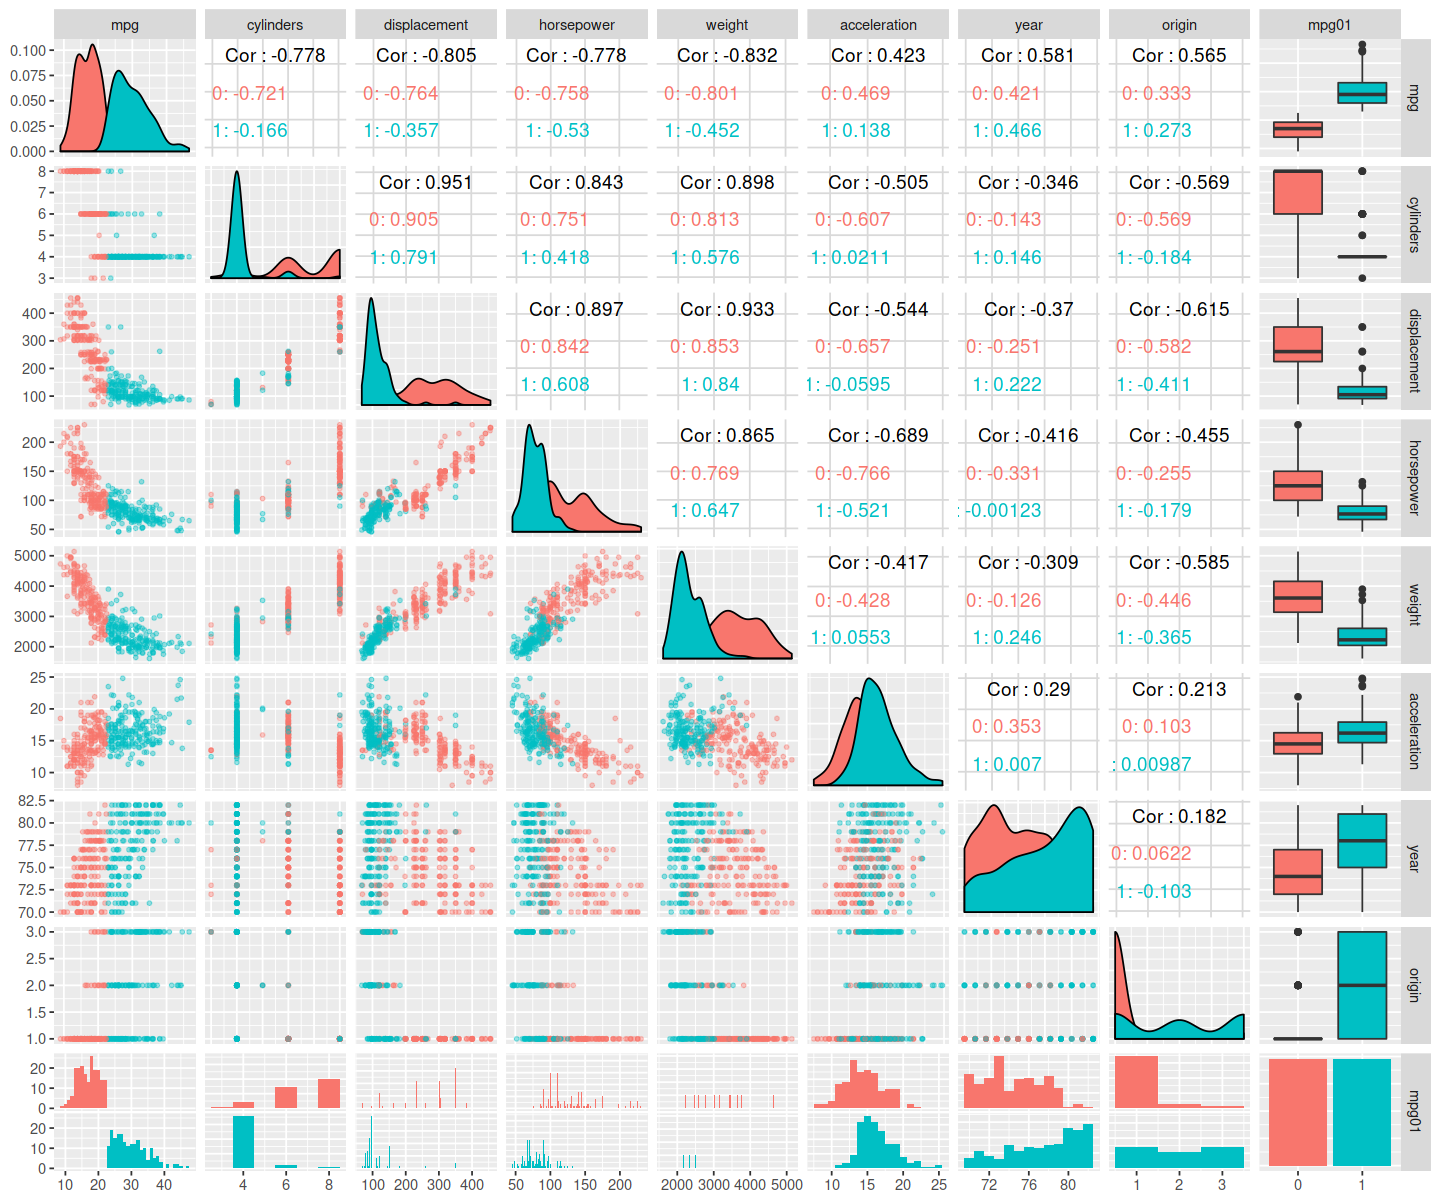

In [124]:
options(repr.plot.height = 10, repr.plot.width = 12, repr.plot.dpi = 600)
set.seed(1)
ggpairs(Auto,
        aes(color = mpg01),
        upper = list(continuous = wrap("cor", size = 4)),
        lower = list(continuous = wrap("points", alpha = 0.4, size = 1),
                     combo = wrap("facethist", binwidth = 1))
)

The most useful features to predict **mpg01** seem to be **displacement**, **horsepower**, and **weight**. Look at the most right-hand column, which arej boxplots of the features against **mpg01**.

c) Split the data into a training set and a test set.

In [125]:
set.seed(1)
train <- sample(nrow(Auto), floor(nrow(Auto) * 0.7))
X.train <- Auto[train, ]
X.test <- Auto[-train, ]

d) Perform LDA on the training data in order to predict **mpg01** using the variables that seemed most associated with **mpg01** in (b). What is the test error of the model obtained?

In [126]:
lda.fit <- lda(mpg01 ~ displacement + horsepower + weight,
               data = X.train)
lda.class <- predict(lda.fit, X.test)$class

print(table(lda.class, X.test$mpg01))

accuracy <- mean(lda.class == X.test$mpg01)
accuracy

         
lda.class  0  1
        0 47  1
        1 10 60


[1] 0.9067797

d) Perform QDA on the training data in order to predict **mpg01** using the variables that seemed most associated with **mpg01** in (b). What is the test error of the model obtained?

In [127]:
qda.fit <- qda(mpg01 ~ displacement + horsepower + weight,
               data = X.train)
qda.class <- predict(qda.fit, X.test)$class

print(table(qda.class, X.test$mpg01))

accuracy <- mean(qda.class == X.test$mpg01)
accuracy

         
qda.class  0  1
        0 47  3
        1 10 58


[1] 0.8898305

f) Perform logistic regression on the training data in order to predict **mpg01** using the variables that seemed most associated with **mpg01** in (b). What is the test error of the model obtained?

In [128]:
lr.fit <- glm(mpg01 ~ displacement + horsepower + weight,
              family = binomial, data = X.train)
lr.pred <- predict(lr.fit, X.test, type = "response")
lr.class <- rep("0", length(lr.pred))
lr.class[lr.pred > .5] <- "1"

print(table(lr.class, X.test$mpg01))

accuracy <- mean(lr.class == X.test$mpg01)
accuracy

        
lr.class  0  1
       0 50  3
       1  7 58


[1] 0.9152542

In [129]:
X <- scale(subset(Auto, select = c(displacement, horsepower, weight)))
knn.X.train <- X[train, ]
knn.X.test <- X[-train, ]
y.train <- Auto[train, "mpg01"]
y.test <- Auto[-train, "mpg01"]

In [130]:
precision <- function(expected, predicted) {
    TP <- sum((expected == "1") & (predicted == "1"))
    FP <- sum((expected == "0") & (predicted == "1"))
    TP / (TP + FP)
}

recall <- function(expected, predicted) {
    TP <- sum((expected == "1") & (predicted == "1"))
    FN <- sum((expected == "1") & (predicted == "0"))
    TP / (TP + FN)
}

registerDoMC(8)
prec.result <- foreach(k = 1:10, .combine = "rbind") %dopar% {
    set.seed(1)
    knn.pred <- knn(X.train, X.test, y.train, k = k)
    prec <- precision(y.test, knn.pred)
    rec <- recall(y.test, knn.pred)
    acc <- mean(y.test == knn.pred)
    c(k = k, precision = prec, recall = rec, accuracy = acc)
}

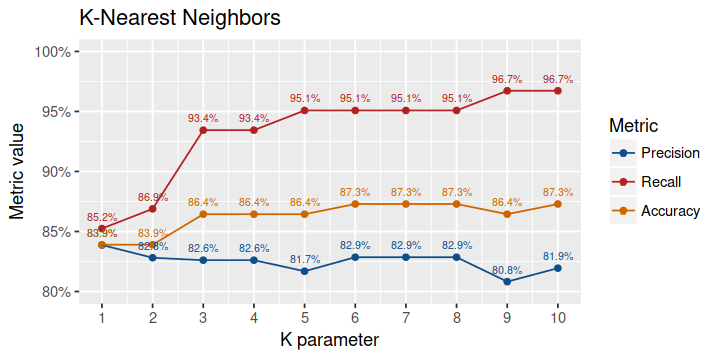

In [131]:
pr.result <- melt(
    data.frame(prec.result), 
    id.vars = c("k"),
    variable.name = "metric"
)

options(repr.plot.width = 6, repr.plot.height = 3, repr.plot.dpi = 600)
ggplot(pr.result, aes(k, value, colour = metric)) +
    geom_point() +
    geom_line() +
    geom_text(aes(label = sprintf("%.1f%%", 100 * value)), 
              size = 2.25, nudge_y = 0.01) +
    scale_x_continuous(breaks = seq(1, 10, 1)) +
    scale_y_continuous(limit = c(0.8, 1), labels = scales::percent) +
    scale_colour_manual(labels = c("Precision", "Recall", "Accuracy"), 
                        values = c("dodgerblue4", "firebrick", "darkorange3")) +
    guides(colour = guide_legend("Metric")) +
    xlab("K parameter") +
    ylab("Metric value") +
    ggtitle("K-Nearest Neighbors")

### Exercise 12 

This problem involves writing functions.

*Skipping it because it is too introductory.*

### Exercise 12


Using the **Boston** data set, fit classification models in order to predict whether a given suburb has a crime rate above or below the median. Explore logistic regression, LDA, and KNN models using various subsets of the predictors. Decribe your findings.

In [132]:
head(Boston)

crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0.00632,18,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
0.02729,0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
0.03237,0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
0.06905,0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
0.02985,0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21,28.7


In [133]:
is.above <- with(Boston, crim > median(crim))
Boston$crim01 <- "0"
Boston[is.above, ]$crim01 <- "1"
Boston$crim01 <- factor(Boston$crim01)

set.seed(1)
train <- sample(nrow(Boston), floor(nrow(Boston) * 0.7))

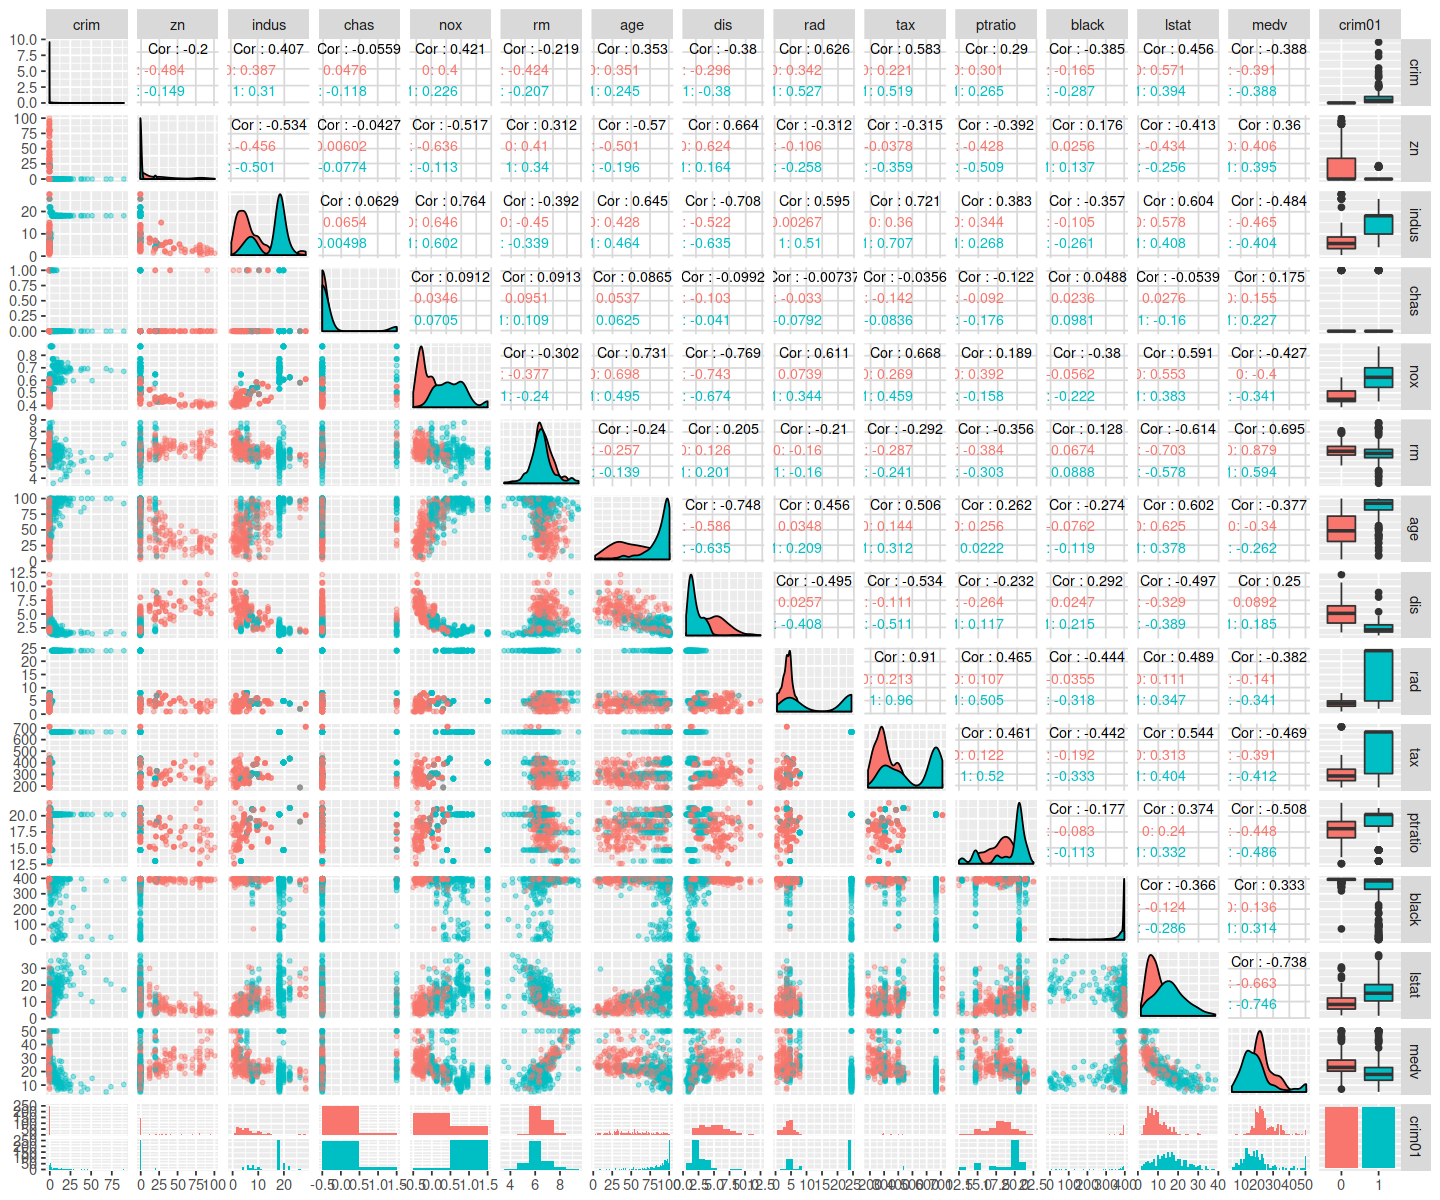

In [134]:
options(repr.plot.height = 10, repr.plot.width = 12, repr.plot.dpi = 600)
set.seed(1)
ggpairs(Boston,
        aes(color = crim01),
        upper = list(continuous = wrap("cor", size = 3)),
        lower = list(continuous = wrap("points", alpha = 0.4, size = 1),
                     combo = wrap("facethist", binwidth = 1))
)

In [135]:
evaluate <- function(predicted, expected) {
    TN <- sum((expected == "0") & (predicted == "0"))
    TP <- sum((expected == "1") & (predicted == "1"))
    FP <- sum((expected == "0") & (predicted == "1"))
    FN <- sum((expected == "1") & (predicted == "0"))
    data.frame(
        accuracy  = (TP + TN) / length(expected),
        precision = TP / (FP + TP),
        recall    = TP / (FN + TP)
    )
}

bin.predict <- function(model, newdata, cut = 0.5) {
    pred <- predict(model, newdata = newdata, type = "response")
    resp <- rep("0", length(pred))
    resp[pred > cut] <- "1"
    factor(resp)
}

In [136]:
X.train <- Boston[train, ]
X.test <- Boston[-train, ]
y.train <- Boston[train, ]$crim01
y.test <- Boston[-train, ]$crim01

##### Logistic Regression

In [137]:
glm.fit <- glm(crim01 ~ log(nox) + rad + dis + tax  + ptratio + 
                        rad*ptratio + rad*dis,
               family = binomial, data = X.train)
evaluate(bin.predict(glm.fit, X.test), X.test$crim01)
summary(glm.fit)

accuracy,precision,recall
0.9473684,0.9594595,0.9342105



Call:
glm(formula = crim01 ~ log(nox) + rad + dis + tax + ptratio + 
    rad * ptratio + rad * dis, family = binomial, data = X.train)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.94650  -0.21539  -0.00609   0.01458   2.90206  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -11.344803   8.530956  -1.330  0.18357    
log(nox)     23.192935   3.807600   6.091 1.12e-09 ***
rad           4.904088   1.687676   2.906  0.00366 ** 
dis           1.343630   0.466947   2.877  0.00401 ** 
tax          -0.008095   0.002896  -2.796  0.00518 ** 
ptratio       1.074379   0.420948   2.552  0.01070 *  
rad:ptratio  -0.189921   0.083896  -2.264  0.02359 *  
rad:dis      -0.194009   0.089329  -2.172  0.02987 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 490.75  on 353  degrees of freedom
Residual deviance: 162.20  on 346  degrees of free

##### Linear Discriminant Analysis

In [138]:
lda.fit <- lda(crim01 ~ nox + dis + tax + rad*ptratio,
               family = binomial, data = X.train)
evaluate(predict(lda.fit, X.test)$class, X.test$crim01)

accuracy,precision,recall
0.9013158,0.984127,0.8157895


##### K-Nearest Neighbors

In [139]:
X <- Boston
X$rad_ptratio <- with(X, rad * ptratio)
crim01.idx <- which(names(Boston) == "crim01")
X[, -crim01.idx] <- scale(X[, -crim01.idx])
features <- c("nox", "dis", "tax", "rad_ptratio", "ptratio")
X.train <- X[train, features]
X.test <- X[-train, features]
y.train <- X[train, "crim01"]
y.test <- X[-train, "crim01"]

In [140]:
precision <- function(expected, predicted) {
    TP <- sum((expected == "1") & (predicted == "1"))
    FP <- sum((expected == "0") & (predicted == "1"))
    TP / (TP + FP)
}

recall <- function(expected, predicted) {
    TP <- sum((expected == "1") & (predicted == "1"))
    FN <- sum((expected == "1") & (predicted == "0"))
    TP / (TP + FN)
}

registerDoMC(8)
prec.result <- foreach(k = 1:10, .combine = "rbind") %dopar% {
    set.seed(1)
    knn.pred <- knn(X.train, X.test, y.train, k = k)
    prec <- precision(y.test, knn.pred)
    rec <- recall(y.test, knn.pred)
    acc <- mean(y.test == knn.pred)
    c(k = k, precision = prec, recall = rec, accuracy = acc)
}

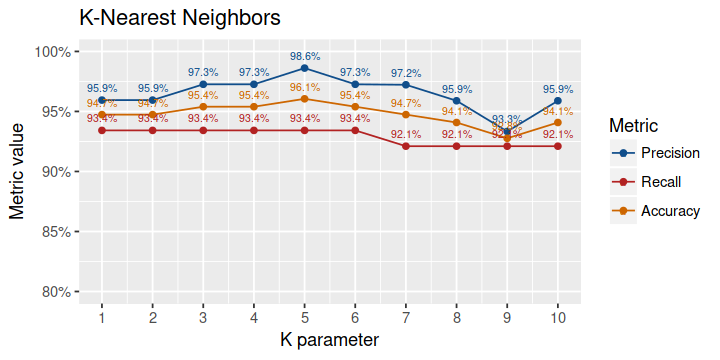

In [141]:
pr.result <- melt(
    data.frame(prec.result), 
    id.vars = c("k"),
    variable.name = "metric"
)

options(repr.plot.width = 6, repr.plot.height = 3, repr.plot.dpi = 600)
ggplot(pr.result, aes(k, value, colour = metric)) +
    geom_point() +
    geom_line() +
    geom_text(aes(label = sprintf("%.1f%%", 100 * value)), 
              size = 2.25, nudge_y = 0.01) +
    scale_x_continuous(breaks = seq(1, 10, 1)) +
    scale_y_continuous(limit = c(0.8, 1), labels = scales::percent) +
    scale_colour_manual(labels = c("Precision", "Recall", "Accuracy"), 
                        values = c("dodgerblue4", "firebrick", "darkorange3")) +
    guides(colour = guide_legend("Metric")) +
    xlab("K parameter") +
    ylab("Metric value") +
    ggtitle("K-Nearest Neighbors")

##### Summary of built models

Model               | Accuracy | Precision | Recall
:------------------ | :------- | :-------- | :-----
Logistic Regression | 94.7%    | 95.9%     | 93.4%
Linear Discriminant Analysis | 90.1% | 98.4% | 81.6%
5-Nearest Neighbors | 96.1%    | 98.6%     | 93.4%

I managed to get the highest accuracy + precision with a 5-NN model. For a inductive model, the logistic regression was better, though with the most parameters.